In [1]:
import torch
from architecture import conv_vgg
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import PIL
from preprocessing.squarepad import SquarePad
from torchvision import transforms
from matplotlib import cm

In [2]:
# Define the transformations.
# For the classification
tran = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        SquarePad(),
        transforms.Resize((224, 224)),
    ])

# For the original image to interpolate with the CAM
tran2 = transforms.Compose([
        transforms.ToTensor(),
        SquarePad(),
    ])

In [3]:
# test image path
img_path = 'test-data/seb.jpg'

# model weights path
weights_path = 'best_vgg_3rd_strategy/vgg_test_best.pth'

In [4]:
# load classes names
with open('sets/vgg_classes.txt', 'r') as f:
    classes = [l.strip() for l in f.readlines()]
print('Loaded {} classes:'.format(len(classes)))
print('\n'.join(classes))

Loaded 10 classes:
11F(MARY)
11H(ANTONY OF PADUA)
11H(DOMINIC)
11H(FRANCIS)
11H(JEROME)
11H(JOHN THE BAPTIST)
11H(PAUL)
11H(PETER)
11H(SEBASTIAN)
11HH(MARY MAGDALENE)


In [5]:
# initialize model
num_classes = 10
model = conv_vgg.ConvVGG(num_classes)
# print(model)

In [6]:
# load weights
model.load_state_dict(torch.load(weights_path), strict=True)
print('Model loaded')

Model loaded


In [7]:
# set model to be run on GPU
model.cuda()
# set model to run on eval mode
model.eval();

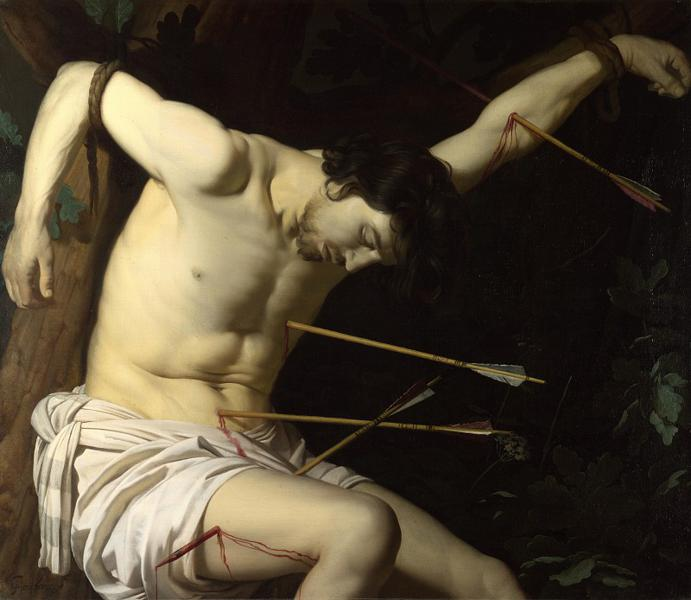

In [8]:
# load image and show
img = PIL.Image.open(img_path)
img

In [9]:
# Transforming the images and sorting dimensions
tensor_img = transforms.ToTensor()(img)
orig_img = tran2(img)
img = tran(img)
img = torch.unsqueeze(img, dim=0)
img.size()

torch.Size([1, 3, 224, 224])

In [10]:
# setting the classification image to cuda, to fit with the model
img = img.cuda()

In [11]:
# run model on img
output = model(img)
probs = output.data.cpu().numpy()
maxprob = np.argmax(probs)
print(probs)
print('')
print(f'class: {maxprob} -- {classes[maxprob]}')

[[ 9.875834  -6.23768   -7.664454  -3.8908207  0.7068113  3.0502582
  -6.4720454 -2.1154454 18.841534  -8.255873 ]]

class: 8 -- 11H(SEBASTIAN)


In [12]:
# instantiate the vgg cam
cam = conv_vgg.CAM(num_classes)
# print(model)

In [13]:
# load weights
cam.load_state_dict(torch.load(weights_path), strict=True)
print('Model loaded')

Model loaded


In [14]:
# set model to be run on GPU
cam.cuda()
# set model to run on eval mode
cam.eval();

In [15]:
# get CAMS from img
cams = cam(img)
print(cams.shape)

torch.Size([1, 10, 14, 14])


In [16]:
# size of original image, with padding
print(orig_img.size())

torch.Size([3, 691, 691])


In [17]:
orig_img = orig_img.permute(1, 2, 0).numpy()
img_size = orig_img.shape[:2]

In [18]:
high_res_cams = F.interpolate(cams, img_size, mode='bilinear', align_corners=False)
print(high_res_cams.shape)

torch.Size([1, 10, 691, 691])


In [19]:
# remove batch dimensions from cams
cams = torch.squeeze(cams, 0)
high_res_cams = torch.squeeze(high_res_cams, 0)
print(cams.shape)
print(high_res_cams.shape)

torch.Size([10, 14, 14])
torch.Size([10, 691, 691])


In [20]:
# min-max normalization
cams /= F.adaptive_max_pool2d(cams, (1, 1)) + 1e-5
high_res_cams /= F.adaptive_max_pool2d(high_res_cams, (1, 1)) + 1e-5

# torch to numpy
cams = cams.data.cpu().numpy()
high_res_cams = high_res_cams.data.cpu().numpy()

In [21]:
CMRmap = cm.get_cmap('jet') # returns RGBA
hrc = CMRmap(high_res_cams[maxprob])
hrc = hrc[:, :, :3] # Remove 4th dim from RGBA

hrc = torch.Tensor(hrc).permute(2, 0, 1)
img = torch.Tensor(orig_img).permute(2, 0, 1)

hrc = SquarePad.remove_padding(tensor_img, hrc)
img = SquarePad.remove_padding(tensor_img, img)

final = PIL.Image.blend(transforms.functional.to_pil_image(hrc), 
                        transforms.functional.to_pil_image(img), 
                        0.5)

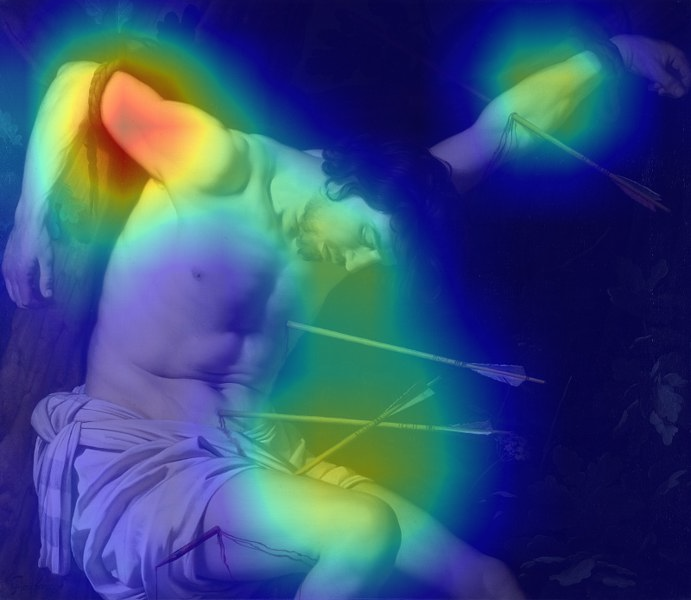

In [22]:
final